In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(context='poster', palette='deep',style='white', font_scale=1)
assert(sns.__version__=='0.11.2')

## Validation via OCTA metrics

In [2]:
norm_VCI = 17962  # Value by Chu et al.
norm_VSD = 0.021  # Value by Chu et al.
norm_VAD = 0.505  # Value by Chu et al.
norm_VPI = 0.05   # Value by Chu et al.
norm_VDI = 24.073 # Value by Chu et al.
norm_VBC = 1.20   # Value by Le et al.
norm_ICD = 22.0   # Value by Liu et al.
norm_FD  = 1.68   # Value by Masters et al.

In [3]:
df = pd.read_csv('GlobalMetrics_forPandas.dat', sep=' ')
df.loc[df.Metric=='VCI', 'Value'] /= norm_VCI
df.loc[df.Metric=='VAD', 'Value'] /= norm_VAD
df.loc[df.Metric=='VSD', 'Value'] /= norm_VSD
df.loc[df.Metric=='VPI', 'Value'] /= norm_VPI
df.loc[df.Metric=='VDI', 'Value'] /= norm_VDI
df.loc[df.Metric=='VBC', 'Value'] /= norm_VBC
df.head(), df.shape

(  Patient Metric     Value
 0       /    VAD  0.370438
 1       /    VPI  0.769559
 2       /    VDI  0.403919
 3       /    VCI  0.189641
 4       /    VSD  0.916141,
 (2400, 3))

### Add ICD data to the dataframe

In [4]:
df_ICD = pd.read_csv('ICD.dat', sep=' ')
maxICD, minICD = df_ICD.Mean.max(), df_ICD.Mean.min()
df_ICD.Mean = df_ICD.Mean/norm_ICD
patients = [int(s.split('/')[-2][-1]) for s in df_ICD['File']]
df2 = pd.DataFrame([[patients[i], 'ICD', df_ICD.at[i,'Mean']] for i in range(df_ICD.shape[0])],
                   columns=['Patient', 'Metric', 'Value'])
print('ICD values between', maxICD,'and', minICD)

ICD values between 26.743531266828622 and 22.150935942116604


In [5]:
df=df.append(df2, ignore_index=True)

### Add FD to the dataframe

In [6]:
df2 = pd.read_csv('FD.dat', sep=' ')
patients = [int(s.split('/')[-2][-1]) for s in df2.File]
FD = [float(fd) for fd in df2.FD]
df2 = pd.DataFrame([[patients[i], 'FD', FD[i]/norm_FD] for i in range(len(FD))],
                   columns=['Patient', 'Metric', 'Value'])
df = df.append(df2, ignore_index=True)

In [7]:
df['Value from'] = ['Artificial vascular networks' for _ in range(df.shape[0])]

In [8]:
ValueFrom = 'Literature'
Chu  = pd.DataFrame([[0,'VAD',0.505/norm_VAD,ValueFrom],
                     [0,'VSD',0.021/norm_VSD,ValueFrom],
                     [0,'VPI',0.05/norm_VPI,ValueFrom],
                     [0,'VCI',17962/norm_VCI,ValueFrom],
                     [0,'VDI',24.073/norm_VDI,ValueFrom]],  
                    columns=['Patient','Metric','Value','Value from'])
Alam = pd.DataFrame([[0,'VAD',0.482/norm_VAD,ValueFrom],
                     [0,'VSD',0.027/norm_VSD,ValueFrom],
                     [0,'VDI',17.84/norm_VDI,ValueFrom]],
                    columns=['Patient','Metric','Value','Value from'])
Le  = pd.DataFrame([[0,'VBC',1.20/norm_VBC,ValueFrom]],
                   columns=['Patient','Metric','Value','Value from'])
Liu = pd.DataFrame([[0,'ICD', 22/norm_ICD,ValueFrom]],   
                   columns=['Patient','Metric','Value','Value from'])
MastersAndMa = pd.DataFrame([[0,'FD', 1.68/norm_FD,ValueFrom], [0, 'FD', 1.45/norm_FD,ValueFrom]],   
                       columns=['Patient','Metric','Value','Value from'])
df = df.append(Chu, ignore_index=True)
df = df.append(Alam, ignore_index=True)
df = df.append(Le, ignore_index=True)
df = df.append(Liu, ignore_index=True)
df = df.append(MastersAndMa, ignore_index=True)

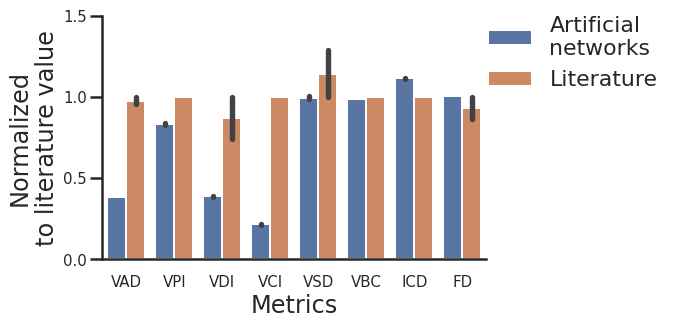

In [9]:
#plt.figure(figsize=(12,4))
Title = "Validation of artificial networks\nusing OCTA metrics\n"
Title = None
g = sns.catplot(data=df, kind='bar', x="Metric", y="Value", hue='Value from', aspect=1.5).set(title=Title)
g.set_ylabels('Normalized\nto literature value')
g.set_yticklabels(g.ax.get_yticklabels(), size=15)
g.set_xticklabels(g.ax.get_xticklabels(), rotation=0, size=15)
g.set_axis_labels('Metrics')
sns.move_legend(g, "lower left", bbox_to_anchor=(0.53, 0.65), title=None)

newLegend = ['Artificial\nnetworks', 'Literature']
for t, l in zip(g._legend.texts, newLegend):
    t.set_text(l)
g.tight_layout()
g.ax.tick_params(left=True)
g.savefig('LiteratureVSArtificial.jpg', dpi=400)

## Geometrical comparison

### Bifurcation diameter ratios

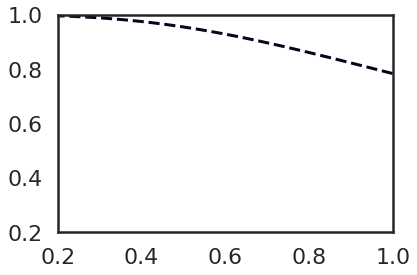

In [10]:
m = 2.85
x = np.linspace(0.2, 1, 500)
y = np.linspace(0.2, 1, 500)
X,Y = np.meshgrid(x,y)
u,v = Y**(-m), 1+x**m
z = u-v

cs = plt.contour(X,Y,z, [0], linestyles='--', linewidths=3)
v = cs.allsegs[0][0]
x,y = v[:,0], v[:,1]


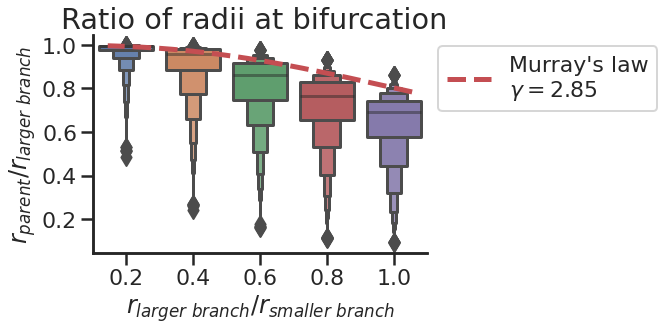

In [11]:
df = pd.read_csv('DiameterRatiosAtBifurcations.dat', sep=' ')
Title = "Ratio of radii at bifurcation\n"
df['Cat'] = pd.cut(df.SmallerBranchOverLarger, bins=[0.0,0.2,0.4,0.6,0.8,1.0])

fig, g = plt.subplots()

sns.boxenplot(data=df, x='Cat', y='LargerBranchOverParent', ax=g)
ax2 = g.twiny()
ax2.plot(x,y,'r--', linewidth=5, label="Murray's law\n"+r"$\gamma=2.85$")

# g.set_ylabel("Larger branch to\nparent ratio")
# g.set_xlabel('Larger to smaller branch ratio')
g.set_ylabel(r'$r_{parent}/r_{larger\ branch}$')
g.set_xlabel(r'$r_{larger\ branch}/r_{smaller\ branch}$')

ax2.set_xticks([])
fig.suptitle(Title)
g.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)


ticks = [0.2,0.4,0.6,0.8,1.0]
g.set_xticklabels(ticks)
g.set_yticks(ticks)
g.set_yticklabels(ticks)
g.tick_params(left=True, bottom=True)

plt.legend(bbox_to_anchor=(1.,1), loc="upper left")
fig.savefig('BifurcationRatios.jpg', dpi=400, bbox_inches='tight')

#### Diameters per branching order

In [12]:
df = pd.read_csv('TreesData.dat', sep=' ')
df['Type'] = ['Artificial networks' for _ in range(len(df))]
df.Order = df.Order.astype(int)

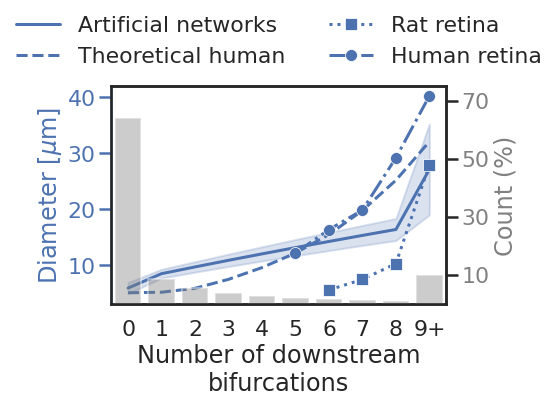

In [13]:
fig = plt.figure()
g = fig.add_subplot(111, label="1")
l1 = sns.lineplot(data=df, x='Order', y='Diameter',ci='sd', 
             ax=g, label='Artificial networks')

color = g.get_lines()[0].get_color()
g.set_ylabel(r'Diameter [$\mu$m]', color=color)
g.spines['left'].set_color(color)
g.yaxis.label.set_color(color)
g.tick_params(axis='y', colors=color)

## Add the data on diameter
takahashi = pd.read_csv('Takahashi.dat', sep=' ', 
                        names=['Bifurcations', 'Diameter','Radius'])
takahashi = takahashi[takahashi.Diameter < 40]
takahashi['Type'] = ['Ideal human\nretinal network' for _ in range(len(takahashi))]
l2 = sns.lineplot(data=takahashi, x='Bifurcations', y='Diameter', linestyle='--',
            ax=g, color=color, label='Theoretical human')
kornfield = pd.read_csv('Kornfield2014.dat', sep=' ',
                       names=['Bifurcations', 'Diameter'])
kornfield['Type'] = ['Rat retina' for _ in range(4)]
l3 = sns.lineplot(data=kornfield, x=[9,8,7,6], y='Diameter', color=color,
            marker='s', linestyle=':', ax=g, label='Rat retina')
an = pd.read_csv('An2020MeanDiameter.dat', sep=' ',
                 names=['Bifurcations', 'Diameter'])
an['Type'] = ['Human retina' for _ in range(len(an))]
l4 = sns.lineplot(data=an, x=[9,8,7,6,5], y='Diameter', color=color,
            marker='o', linestyle='dashdot', ax=g, label='Human retina')
handles = [l1,l2,l3,l4]
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)
g.invert_xaxis()

color = 'gray'
g1 = g.twinx()
g1.set_ylim(0,75)
sns.barplot(x="Order", y="Order", data=df, estimator=lambda x: len(x) / len(df) * 100, ax=g1, color=color,alpha=0.4)
g1.set_ylabel("Count (%)", color=color)
g1.set_yticks([10,30,50,70])
g1.set_yticklabels([10,30,50,70], color=color)
#sns.countplot(data=df, x='Order', ax=g1, color='gray', alpha=0.4)

g.set_xticks([0,1,2,3,4,5,6,7,8,9])
g.set_xticklabels([0,1,2,3,4,5,6,7,8,'9+'])
g.set_xlabel('Number of downstream\nbifurcations')


fig.savefig("DiametersPerBifurcationOrder.jpg", dpi=400, bbox_inches='tight')

In [4]:
def moving_avg(x, N=300):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

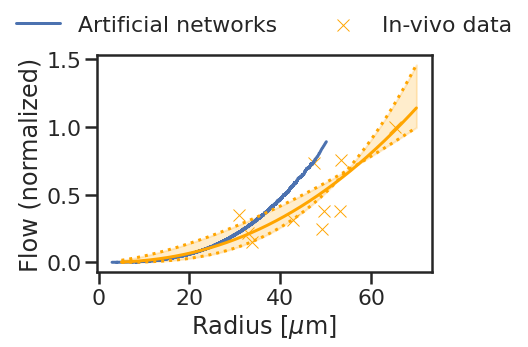

In [43]:
fig = plt.figure()
g = fig.add_subplot(111)
color = 'orange'

df = pd.read_csv('DiameterAndFlow.csv')
df = df.sort_values(by='Diameter')
g.plot(moving_avg(df.Diameter), moving_avg(df.Flow/df.Flow.max()),
       label='Artificial networks')


flow = pd.read_csv('Data_FlowVSDiameter.csv', names=['Diameter', 'Flow'])
flow.Diameter = flow.Diameter.apply(lambda x: 10**x)
flow.Flow = flow.Flow.apply(lambda x:10**x)
maxQ = flow.Flow.max()
flow.Flow = flow.Flow.apply(lambda x:x/maxQ)

sns.scatterplot(data=flow, x='Diameter', y='Flow', ax=g, color=color, marker='x', label='In-vivo data')

## Add linear regression lines
x = [1.4, 1.5078488372093024]
y = [-0.8636363636363633,-0.6212121212121211]
a0 = (y[0]-y[1])/(x[0]-x[1])
b0 = -4.0

x = [1.4, 1.5261627906976745]
y = [-0.6060606060606055, -0.4090909090909083]
a1 = (y[0]-y[1])/(x[0]-x[1])
b1 = y[0]-a1*x[0]

x = [1.4, 1.5078488372093024]
y = [-1.1212121212121193, -0.7878787878787872]
a2 = (y[0]-y[1])/(x[0]-x[1])
b2 = y[0]-a2*x[0]

D = np.linspace(5, 70, 1000)

def f(d,a,b):
    return np.array(d)**a * 10**b

y0,y1,y2 = f(D,a0,b0), f(D,a1,b1), f(D,a2,b2) 
norm = maxQ

g.plot(D, y0/norm, color=color, label='Curve fit and 95% confidence intervals')
g.plot(D, y1/norm, linestyle='dotted', color=color)
g.plot(D, y2/norm, linestyle='dotted', color=color)
g.fill_between(D, y1/norm, y2/norm,alpha=0.2, color=color)

g.set_ylabel(r'Flow (normalized)')
g.set_xlabel(r'Radius [$\mu$m]')

sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)
g.tick_params(bottom=True, left=True)

fig.savefig("FlowValidation.jpg", dpi=400, bbox_inches='tight')